# Assignment 2:  Deep N-grams

Welcome to the second assignment of course 3. In this assignment you will explore Recurrent Neural Networks `RNN`.
- You will be using the fundamentals of google's [trax](https://github.com/google/trax) package to implement any kind of deeplearning model. 

By completing this assignment, you will learn how to implement models from scratch:
- How to convert a line of text into a tensor
- Create an iterator to feed data to the model
- Define a GRU model using `trax`
- Train the model using `trax`
- Compute the accuracy of your model using the perplexity
- Predict using your own model

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader Error: Grader feedback not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/sequence-models-in-nlp/supplement/6ThZO/how-to-refresh-your-workspace).

## Table of Contents

- [Overview](#0)
- [1 - Importing the Data](#1)
    - [1.1 - Loading in the Data](#1-1)
    - [1.2 - Convert a Line to Tensor](#1-2)
        - [Exercise 1 - line_to_tensor (UNQ_C1)](#ex-1)
    - [1.3 - Batch Generator](#1-3)
        - [Exercise 2 - data_generator (UNQ_C2)](#ex-2)
    - [1.4 - Repeating Batch Generator](#1-4)        
- [2 - Defining the GRU Model](#2)
    - [Exercise 3 - GRULM (UNQ_C3)](#ex-3)
- [3 - Training](#3)
    - [3.1 - Training the Model](#3-1)
        - [Exercise 4 - train_model (UNQ_C4)](#ex-4)
- [4 - Evaluation](#4)
    - [4.1 - Evaluating using the Deep Nets](#4-1)
        - [Exercise 5 - test_model (UNQ_C5)](#ex-5)
- [5 - Generating the Language with your Own Model](#5)    
- [Summary](#6)


<a name='0'></a>
## Overview

Your task will be to predict the next set of characters using the previous characters. 
- Although this task sounds simple, it is pretty useful.
- You will start by converting a line of text into a tensor
- Then you will create a generator to feed data into the model
- You will train a neural network in order to predict the new set of characters of defined length. 
- You will use embeddings for each character and feed them as inputs to your model. 
    - Many natural language tasks rely on using embeddings for predictions. 
- Your model will convert each character to its embedding, run the embeddings through a Gated Recurrent Unit `GRU`, and run it through a linear layer to predict the next set of characters.

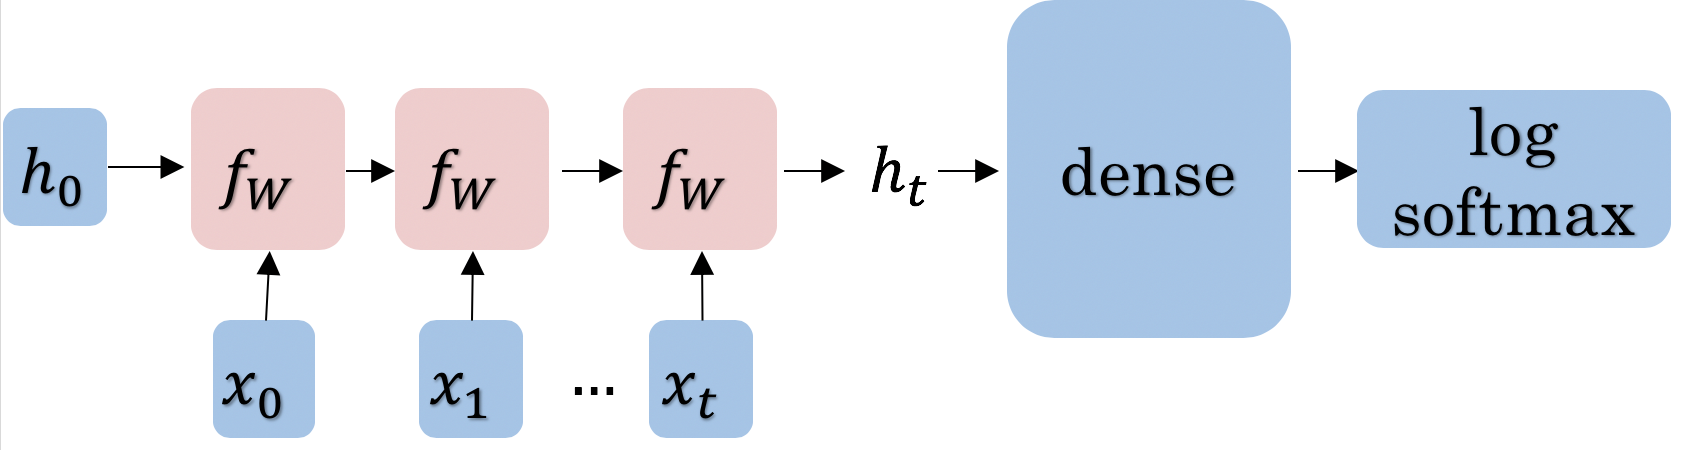

The figure above gives you a summary of what you are about to implement. 
- You will get the embeddings;
- Stack the embeddings on top of each other;
- Run them through two layers with a relu activation in the middle;
- Finally, you will compute the softmax. 

To predict the next character:
- Use the softmax output and identify the word with the highest probability.
- The word with the highest probability is the prediction for the next word.

In [1]:
import os
import shutil
import trax
import trax.fastmath.numpy as np
import pickle
import numpy
import random as rnd
from trax import fastmath
from trax import layers as tl

import w2_unittest

# set random seed
rnd.seed(32)

<a name='1'></a>
## 1 - Importing the Data

<a name='1-1'></a>
### 1.1 - Loading in the Data

Now import the dataset and do some processing. 
- The dataset has one sentence per line.
- You will be doing character generation, so you have to process each sentence by converting each **character** (and not word) to a number. 
- You will use the `ord` function to convert a unique character to a unique integer ID. 
- Store each line in a list.
- Create a data generator that takes in the `batch_size` and the `max_length`. 
    - The `max_length` corresponds to the maximum length of the sentence.

In [2]:
dirname = 'data/'
filename = 'shakespeare_data.txt'
lines = [] # storing all the lines in a variable. 

counter = 0

with open(os.path.join(dirname, filename)) as files:
    for line in files:        
        # remove leading and trailing whitespace
        pure_line = line.strip()

        # if pure_line is not the empty string,
        if pure_line:
            # append it to the list
            lines.append(pure_line)

In [3]:
n_lines = len(lines)
print(f"Number of lines: {n_lines}")
print(f"Sample line at position 0 {lines[0]}")
print(f"Sample line at position 999 {lines[999]}")

Number of lines: 125097
Sample line at position 0 A LOVER'S COMPLAINT
Sample line at position 999 With this night's revels and expire the term


Notice that the letters are both uppercase and lowercase.  In order to reduce the complexity of the task, we will convert all characters to lowercase.  This way, the model only needs to predict the likelihood that a letter is 'a' and not decide between uppercase 'A' and lowercase 'a'.

In [4]:
# go through each line
for i, line in enumerate(lines):
    # convert to all lowercase
    lines[i] = line.lower()

print(f"Number of lines: {n_lines}")
print(f"Sample line at position 0 {lines[0]}")
print(f"Sample line at position 999 {lines[999]}")

Number of lines: 125097
Sample line at position 0 a lover's complaint
Sample line at position 999 with this night's revels and expire the term


In [5]:
eval_lines = lines[-1000:] # Create a holdout validation set
lines = lines[:-1000] # Leave the rest for training

print(f"Number of lines for training: {len(lines)}")
print(f"Number of lines for validation: {len(eval_lines)}")

Number of lines for training: 124097
Number of lines for validation: 1000


<a name='1-2'></a>
### 1.2 - Convert a Line to Tensor

Now that you have your list of lines, you will convert each character in that list to a number. You can use Python's `ord` function to do it. 

Given a string representing of one Unicode character, the `ord` function return an integer representing the Unicode code point of that character.



In [6]:
# View the unique unicode integer associated with each character
print(f"ord('a'): {ord('a')}")
print(f"ord('b'): {ord('b')}")
print(f"ord('c'): {ord('c')}")
print(f"ord(' '): {ord(' ')}")
print(f"ord('x'): {ord('x')}")
print(f"ord('y'): {ord('y')}")
print(f"ord('z'): {ord('z')}")
print(f"ord('1'): {ord('1')}")
print(f"ord('2'): {ord('2')}")
print(f"ord('3'): {ord('3')}")

ord('a'): 97
ord('b'): 98
ord('c'): 99
ord(' '): 32
ord('x'): 120
ord('y'): 121
ord('z'): 122
ord('1'): 49
ord('2'): 50
ord('3'): 51


<a name='ex-1'></a>
### Exercise 1 - line_to_tensor

**Instructions:** Write a function that takes in a single line and transforms each character into its unicode integer.  This returns a list of integers, which we'll refer to as a tensor.
- Use a special integer to represent the end of the sentence (the end of the line).
- This will be the EOS_int (end of sentence integer) parameter of the function.
- Include the EOS_int as the last integer of the 
- For this exercise, you will use the number `1` to represent the end of a sentence.

In [13]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: line_to_tensor
def line_to_tensor(line, EOS_int=1):
    """Turns a line of text into a tensor

    Args:
        line (str): A single line of text.
        EOS_int (int, optional): End-of-sentence integer. Defaults to 1.

    Returns:
        list: a list of integers (unicode values) for the characters in the `line`.
    """
    
    # Initialize the tensor as an empty list
    tensor = []
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # for each character:
    for c in line:
        
        # convert to unicode int
        c_int = ord(c)
        
        # append the unicode integer to the tensor list
        tensor.append(c_int)
    
    # include the end-of-sentence integer
    tensor.append(EOS_int)
    
    ### END CODE HERE ###

    return tensor

In [14]:
# Testing your output
line_to_tensor('abc xyz')

[97, 98, 99, 32, 120, 121, 122, 1]

##### Expected Output
```CPP
[97, 98, 99, 32, 120, 121, 122, 1]
```

In [15]:
# Test your function
w2_unittest.test_line_to_tensor(line_to_tensor)

 All tests passed


<a name='1-3'></a>
### 1.3 - Batch Generator 

Most of the time in Natural Language Processing, and AI in general we use batches when training our data sets. Here, you will build a data generator that takes in a text and returns a batch of text lines (lines are sentences).
- The generator converts text lines (sentences) into numpy arrays of integers padded by zeros so that all arrays have the same length, which is the length of the longest sentence in the entire data set.

Once you create the generator, you can iterate on it like this:

```
next(data_generator)
```

This generator returns the data in a format that you could directly use in your model when computing the feed-forward of your algorithm. This iterator returns a batch of lines and per token mask. The batch is a tuple of three parts: inputs, targets, mask. The inputs and targets are identical. The second column will be used to evaluate your predictions. Mask is 1 for non-padding tokens.

<a name='ex-2'></a>
### Exercise 2 - data_generator
**Instructions:** Implement the data generator below. Here are some things you will need. 

- While True loop: this will yield one batch at a time.
- if index >= num_lines, set index to 0. 
- The generator should return shuffled batches of data. To achieve this without modifying the actual lines a list containing the indexes of `data_lines` is created. This list can be shuffled and used to get random batches everytime the index is reset.
- if len(line) < max_length append line to cur_batch.
    - Note that a line that has length equal to max_length should not be appended to the batch. 
    - This is because when converting the characters into a tensor of integers, an additional end of sentence token id will be added.  
    - So if max_length is 5, and a line has 4 characters, the tensor representing those 4 characters plus the end of sentence character will be of length 5, which is the max length.
- if len(cur_batch) == batch_size, go over every line, convert it to an int and store it.

**Remember that when calling np you are really calling trax.fastmath.numpy which is trax’s version of numpy that is compatible with JAX. As a result of this, where you used to encounter the type numpy.ndarray now you will find the type jax.interpreters.xla.DeviceArray.**

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Use the line_to_tensor function above inside a list comprehension in order to pad lines with zeros.</li>
    <li>Keep in mind that the length of the tensor is always 1 + the length of the original line of characters.  Keep this in mind when setting the padding of zeros.</li>
</ul>
</p>

In [16]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: data_generator
def data_generator(batch_size, max_length, data_lines, line_to_tensor=line_to_tensor, shuffle=True):
    """Generator function that yields batches of data

    Args:
        batch_size (int): number of examples (in this case, sentences) per batch.
        max_length (int): maximum length of the output tensor.
        NOTE: max_length includes the end-of-sentence character that will be added
                to the tensor.  
                Keep in mind that the length of the tensor is always 1 + the length
                of the original line of characters.
        data_lines (list): list of the sentences to group into batches.
        line_to_tensor (function, optional): function that converts line to tensor. Defaults to line_to_tensor.
        shuffle (bool, optional): True if the generator should generate random batches of data. Defaults to True.

    Yields:
        tuple: two copies of the batch (jax.interpreters.xla.DeviceArray) and mask (jax.interpreters.xla.DeviceArray).
        NOTE: jax.interpreters.xla.DeviceArray is trax's version of numpy.ndarray
    """
    # initialize the index that points to the current position in the lines index array
    index = 0
    
    # initialize the list that will contain the current batch
    cur_batch = []
    
    # count the number of lines in data_lines
    num_lines = len(data_lines)
    
    # create an array with the indexes of data_lines that can be shuffled
    lines_index = [*range(num_lines)]
    
    # shuffle line indexes if shuffle is set to True
    if shuffle:
        rnd.shuffle(lines_index)
    
    ### START CODE HERE ###
    while True:
        
        # if the index is greater than or equal to the number of lines in data_lines
        if index >= num_lines:
            # then reset the index to 0
            index = 0
            # shuffle line indexes if shuffle is set to True
            if shuffle:
                rnd.shuffle(lines_index) 
                            
        # get a line at the `lines_index[index]` position in data_lines
        line = data_lines[lines_index[index]]
        
        # if the length of the line is less than max_length
        if len(line) < max_length:
            # append the line to the current batch
            cur_batch.append(line)
            
        # increment the index by one
        index += 1
        
        # if the current batch is now equal to the desired batch size
        if len(cur_batch) == batch_size:
            
            batch = []
            mask = []
            
            # go through each line (li) in cur_batch
            for li in cur_batch:
                # convert the line (li) to a tensor of integers
                tensor = line_to_tensor(li)
                
                # Create a list of zeros to represent the padding
                # so that the tensor plus padding will have length `max_length`
                pad = [0] * (max_length - len(tensor))
                
                # combine the tensor plus pad
                tensor_pad = tensor + pad
                
                # append the padded tensor to the batch
                batch.append(tensor_pad)

                # A mask for this tensor_pad is 1 whereever tensor_pad is not
                # 0 and 0 whereever tensor_pad is 0, i.e. if tensor_pad is
                # [1, 2, 3, 0, 0, 0] then example_mask should be
                # [1, 1, 1, 0, 0, 0]
                example_mask = [1 if t != 0 else 0 for t in tensor_pad]
                mask.append(example_mask) # @ KEEPTHIS
               
            # convert the batch (data type list) to a numpy array
            batch_np_arr = np.array(batch)
            mask_np_arr = np.array(mask)
            
            ### END CODE HERE ##
            
            # Yield two copies of the batch and mask.
            yield batch_np_arr, batch_np_arr, mask_np_arr
            
            # reset the current batch to an empty list
            cur_batch = []
            

In [17]:
# Try out your data generator
tmp_lines = ['12345678901', #length 11
             '123456789', # length 9
             '234567890', # length 9
             '345678901'] # length 9

# Get a batch size of 2, max length 10
tmp_data_gen = data_generator(batch_size=2, 
                              max_length=10, 
                              data_lines=tmp_lines,
                              shuffle=False)

# get one batch
tmp_batch = next(tmp_data_gen)

# view the batch
tmp_batch

(DeviceArray([[49, 50, 51, 52, 53, 54, 55, 56, 57,  1],
              [50, 51, 52, 53, 54, 55, 56, 57, 48,  1]], dtype=int32),
 DeviceArray([[49, 50, 51, 52, 53, 54, 55, 56, 57,  1],
              [50, 51, 52, 53, 54, 55, 56, 57, 48,  1]], dtype=int32),
 DeviceArray([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32))

##### Expected output

```CPP
(DeviceArray([[49, 50, 51, 52, 53, 54, 55, 56, 57,  1],
              [50, 51, 52, 53, 54, 55, 56, 57, 48,  1]], dtype=int32),
 DeviceArray([[49, 50, 51, 52, 53, 54, 55, 56, 57,  1],
              [50, 51, 52, 53, 54, 55, 56, 57, 48,  1]], dtype=int32),
 DeviceArray([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32))
```

In [18]:
# Test your function
w2_unittest.test_data_generator(data_generator)

 All tests passed


Now that you have your generator, you can just call them and they will return tensors which correspond to your lines in Shakespeare. The first column and the second column are identical. Now you can go ahead and start building your neural network. 

<a name='1-4'></a>
### 1.4 - Repeating Batch Generator 

The way the iterator is currently defined, it will keep providing batches forever.

Although it is not needed, we want to show you the `itertools.cycle` function which is really useful when the generator eventually stops

Notice that it is expected to use this function within the training function further below

Usually we want to cycle over the dataset multiple times during training (i.e. train for multiple *epochs*).

For small datasets we can use [`itertools.cycle`](https://docs.python.org/3.8/library/itertools.html#itertools.cycle) to achieve this easily.

In [19]:
import itertools

infinite_data_generator = itertools.cycle(
    data_generator(batch_size=2, max_length=10, data_lines=tmp_lines))

You can see that we can get more than the 5 lines in tmp_lines using this.

In [20]:
ten_lines = [next(infinite_data_generator) for _ in range(10)]
print(len(ten_lines))

10


<a name='2'></a>
## 2 - Defining the GRU Model

Now that you have the input and output tensors, you will go ahead and initialize your model. You will be implementing the `GRULM`, gated recurrent unit model. To implement this model, you will be using google's `trax` package. Instead of making you implement the `GRU` from scratch, we will give you the necessary methods from a build in package. You can use the following packages when constructing the model: 


- `tl.Serial`: Combinator that applies layers serially (by function composition). [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Serial) / [source code](https://github.com/google/trax/blob/e65d51fe584b10c0fa0fccadc1e70b6330aac67e/trax/layers/combinators.py#L26)
    - You can pass in the layers as arguments to `Serial`, separated by commas. 
    - For example: `tl.Serial(tl.Embeddings(...), tl.Mean(...), tl.Dense(...), tl.LogSoftmax(...))`

___

- `tl.ShiftRight`: Allows the model to go right in the feed forward. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.attention.ShiftRight) / [source code](https://github.com/google/trax/blob/e65d51fe584b10c0fa0fccadc1e70b6330aac67e/trax/layers/attention.py#L560)
    - `ShiftRight(n_shifts=1, mode='train')` layer to shift the tensor to the right n_shift times
    - Here in the exercise you only need to specify the mode and not worry about n_shifts

___

- `tl.Embedding`: Initializes the embedding. In this case it is the size of the vocabulary by the dimension of the model. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Embedding) / [source code](https://github.com/google/trax/blob/e65d51fe584b10c0fa0fccadc1e70b6330aac67e/trax/layers/core.py#L130) 
    - `tl.Embedding(vocab_size, d_feature)`.
    - `vocab_size` is the number of unique words in the given vocabulary.
    - `d_feature` is the number of elements in the word embedding (some choices for a word embedding size range from 150 to 300, for example).
___

- `tl.GRU`: `Trax` GRU layer. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.rnn.GRU) / [source code](https://github.com/google/trax/blob/e65d51fe584b10c0fa0fccadc1e70b6330aac67e/trax/layers/rnn.py#L154)
    - `GRU(n_units)` Builds a traditional GRU of n_cells with dense internal transformations.
    - `GRU` paper: https://arxiv.org/abs/1412.3555
___

- `tl.Dense`: A dense layer. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) / [source code](https://github.com/google/trax/blob/e65d51fe584b10c0fa0fccadc1e70b6330aac67e/trax/layers/core.py#L34)
    - `tl.Dense(n_units)`: The parameter `n_units` is the number of units chosen for this dense layer.
___

- `tl.LogSoftmax`: Log of the output probabilities. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.LogSoftmax) / [source code](https://github.com/google/trax/blob/e65d51fe584b10c0fa0fccadc1e70b6330aac67e/trax/layers/core.py#L644)
    - Here, you don't need to set any parameters for `LogSoftMax()`.
___

<a name='ex-3'></a>
### Exercise 3 - GRULM
**Instructions:** Implement the `GRULM` class below. You should be using all the methods explained above.


In [31]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: GRULM
def GRULM(vocab_size=256, d_model=512, n_layers=2, mode='train'):
    """Returns a GRU language model.

    Args:
        vocab_size (int, optional): Size of the vocabulary. Defaults to 256.
        d_model (int, optional): Depth of embedding (n_units in the GRU cell). Defaults to 512.
        n_layers (int, optional): Number of GRU layers. Defaults to 2.
        mode (str, optional): 'train', 'eval' or 'predict', predict mode is for fast inference. Defaults to "train".

    Returns:
        trax.layers.combinators.Serial: A GRU language model as a layer that maps from a tensor of tokens to activations over a vocab set.
    """
    ### START CODE HERE ###
    model = tl.Serial( 
      tl.ShiftRight(mode='train'),  # ShiftRight layer for processing sequences
      tl.Embedding(vocab_size, d_model),  # Embedding layer
      [tl.GRU(d_model) for _ in range(n_layers)],  # Stack GRU layers
      tl.Dense(vocab_size),  # Dense layer for generating output logits
      tl.LogSoftmax(),  # Log Softmax for probability distribution
    ) 
    ### END CODE HERE ###
    return model


In [32]:
# testing your model
model = GRULM()
print(model)

Serial[
  Serial[
    ShiftRight(1)
  ]
  Embedding_256_512
  GRU_512
  GRU_512
  Dense_256
  LogSoftmax
]


##### Expected output

```python
Serial[
  Serial[
    ShiftRight(1)
  ]
  Embedding_256_512
  GRU_512
  GRU_512
  Dense_256
  LogSoftmax
]
```

In [33]:
# Test your function
w2_unittest.test_GRULM(GRULM)

 All tests passed


<a name='3'></a>
## 3 - Training

Now you are going to train your model. As usual, you have to define the cost function, the optimizer, and decide whether you will be training it on a `gpu` or `cpu`. You also have to feed in a built model. Before, going into the training, we re-introduce the `TrainTask` and `EvalTask` abstractions from the last week's assignment.

To train a model on a task, Trax defines an abstraction `trax.supervised.training.TrainTask` which packages the train data, loss and optimizer (among other things) together into an object.

Similarly to evaluate a model, Trax defines an abstraction `trax.supervised.training.EvalTask` which packages the eval data and metrics (among other things) into another object.

The final piece tying things together is the `trax.supervised.training.Loop` abstraction that is a very simple and flexible way to put everything together and train the model, all the while evaluating it and saving checkpoints.
Using `training.Loop` will save you a lot of code compared to always writing the training loop by hand, like you did in courses 1 and 2. More importantly, you are less likely to have a bug in that code that would ruin your training.

In [34]:
batch_size = 32
max_length = 64

An `epoch` is traditionally defined as one pass through the dataset.

Since the dataset was divided in `batches` you need several `steps` (gradient evaluations) in order to complete an `epoch`. So, one `epoch` corresponds to the number of examples in a `batch` times the number of `steps`. In short, in each `epoch` you go over all the dataset. 

The `max_length` variable defines the maximum length of lines to be used in training our data, lines longer than that length are discarded. 

Below is a function and results that indicate how many lines conform to our criteria of maximum length of a sentence in the entire dataset and how many `steps` are required in order to cover the entire dataset which in turn corresponds to an `epoch`.

In [35]:
def n_used_lines(lines, max_length):
    '''
    Args:
    lines: all lines of text an array of lines
    max_length - max_length of a line in order to be considered an int
    output_dir - folder to save your file an int
    Return:
    number of efective examples
    '''

    n_lines = 0
    for l in lines:
        if len(l) <= max_length:
            n_lines += 1
    return n_lines

num_used_lines = n_used_lines(lines, 32)
print('Number of used lines from the dataset:', num_used_lines)
print('Batch size (a power of 2):', int(batch_size))
steps_per_epoch = int(num_used_lines/batch_size)
print('Number of steps to cover one epoch:', steps_per_epoch)

Number of used lines from the dataset: 25881
Batch size (a power of 2): 32
Number of steps to cover one epoch: 808


**Expected output:** 

Number of used lines from the dataset: 25881

Batch size (a power of 2): 32

Number of steps to cover one epoch: 808

<a name='3-1'></a>
### 3.1 - Training the Model

You will now write a function that takes in your model and trains it. To train your model you have to decide how many times you want to iterate over the entire data set. 

<a name='ex-4'></a>
### Exercise 4 - train_model

**Instructions:** Implement the `train_model` program below to train the neural network above. Here is a list of things you should do:

- Create a `trax.supervised.training.TrainTask` object, this encapsulates the aspects of the dataset and the problem at hand:
    - labeled_data = the labeled data that we want to *train* on.
    - loss_fn = [tl.CrossEntropyLoss()](https://trax-ml.readthedocs.io/en/latest/trax.layers.html?highlight=CrossEntropyLoss#trax.layers.metrics.CrossEntropyLoss)
    - optimizer = [trax.optimizers.Adam()](https://trax-ml.readthedocs.io/en/latest/trax.optimizers.html?highlight=Adam#trax.optimizers.adam.Adam) with learning rate = 0.0005

- Create a `trax.supervised.training.EvalTask` object, this encapsulates aspects of evaluating the model:
    - labeled_data = the labeled data that we want to *evaluate* on.
    - metrics = [tl.CrossEntropyLoss()](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.metrics.CrossEntropyLoss) and [tl.Accuracy()](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.metrics.Accuracy)
    - How frequently we want to evaluate and checkpoint the model.

- Create a `trax.supervised.training.Loop` object, this encapsulates the following:
    - The previously created `TrainTask` and `EvalTask` objects.
    - the training model = [GRULM](#ex03)
    - optionally the evaluation model, if different from the training model. NOTE: in presence of Dropout etc we usually want the evaluation model to behave slightly differently than the training model.

You will be using a cross entropy loss, with Adam optimizer. Please read the [trax](https://trax-ml.readthedocs.io/en/latest/index.html) documentation to get a full understanding. Make sure you use the number of steps provided as a parameter to train for the desired number of steps.

**NOTE:** Don't forget to wrap the data generator in `itertools.cycle` to iterate on it for multiple epochs.

In [36]:
from trax.supervised import training

# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: train_model
def train_model(model, data_generator, lines, eval_lines, batch_size=32, max_length=64, n_steps=1, output_dir='model/'): 
    """Function that trains the model

    Args:
        model (trax.layers.combinators.Serial): GRU model.
        data_generator (function): Data generator function.
        batch_size (int, optional): Number of lines per batch. Defaults to 32.
        max_length (int, optional): Maximum length allowed for a line to be processed. Defaults to 64.
        lines (list): List of lines to use for training. Defaults to lines.
        eval_lines (list): List of lines to use for evaluation. Defaults to eval_lines.
        n_steps (int, optional): Number of steps to train. Defaults to 1.
        output_dir (str, optional): Relative path of the directory to save the model. Defaults to "model/".

    Returns:
        trax.supervised.training.Loop: Training loop for the model.
    """
    
    ### START CODE HERE ###
    bare_train_generator = data_generator(batch_size, max_length, lines)
    infinite_train_generator = itertools.cycle(bare_train_generator)
    
    bare_eval_generator = data_generator(batch_size, max_length, eval_lines)
    infinite_eval_generator = itertools.cycle(bare_eval_generator)
    
    train_task = training.TrainTask( 
        labeled_data=infinite_train_generator,  # Use infinite train data generator
        loss_layer=tl.CrossEntropyLoss(),       # Instantiate CrossEntropyLoss
        optimizer=trax.optimizers.Adam(learning_rate=0.0005)  # Instantiate Adam optimizer with learning rate
    ) 
    
    eval_task = training.EvalTask( 
        labeled_data=infinite_eval_generator,    # Use infinite eval data generator
        metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],  # Instantiate CrossEntropyLoss and Accuracy metrics
        n_eval_batches=3  # For better evaluation accuracy in a reasonable time 
    ) 
    
    training_loop = training.Loop(model, 
                                  train_task, 
                                  eval_tasks=[eval_task], 
                                  output_dir=output_dir) 

    training_loop.run(n_steps=n_steps)
    
    ### END CODE HERE ###
    
    # We return this because it contains a handle to the model, which has the weights, etc.
    return training_loop


In [37]:
# Train the model 1 step and keep the `trax.supervised.training.Loop` object.
output_dir = './model/'

try:
    shutil.rmtree(output_dir)
except OSError as e:
    pass

training_loop = train_model(GRULM(), data_generator, lines=lines, eval_lines=eval_lines)


Step      1: Total number of trainable weights: 3411200
Step      1: Ran 1 train steps in 6.75 secs
Step      1: train CrossEntropyLoss |  5.54517174
Step      1: eval  CrossEntropyLoss |  5.54103247
Step      1: eval          Accuracy |  0.17128430


The model was only trained for 1 step due to the constraints of this environment. Even on a GPU accelerated environment it will take many hours for it to achieve a good level of accuracy. For the rest of the assignment you will be using a pretrained model but now you should understand how the training can be done using Trax.

In [38]:
# Test your function. This cell may take some seconds to execute.
w2_unittest.test_train_model(train_model, GRULM(), data_generator)


Step      1: Total number of trainable weights: 3411200
Step      1: Ran 1 train steps in 12.92 secs
Step      1: train CrossEntropyLoss |  5.54512787
Step      1: eval  CrossEntropyLoss |  5.54265658
Step      1: eval          Accuracy |  0.05755455
 All tests passed


<a name='4'></a>
## 4 - Evaluation  
<a name='4-1'></a>
### 4.1 - Evaluating using the Deep Nets

Now that you have learned how to train a model, you will learn how to evaluate it. To evaluate language models, we usually use perplexity which is a measure of how well a probability model predicts a sample. Note that perplexity is defined as: 

$$P(W) = \sqrt[N]{\prod_{i=1}^{N} \frac{1}{P(w_i| w_1,...,w_{n-1})}}$$

As an implementation hack, you would usually take the log of that formula (to enable us to use the log probabilities we get as output of our `RNN`, convert exponents to products, and products into sums which makes computations less complicated and computationally more efficient). You should also take care of the padding, since you do not want to include the padding when calculating the perplexity (because we do not want to have a perplexity measure artificially good).


$$\log P(W) = {\log\left(\sqrt[N]{\prod_{i=1}^{N} \frac{1}{P(w_i| w_1,...,w_{n-1})}}\right)}$$$$ = \log\left(\left(\prod_{i=1}^{N} \frac{1}{P(w_i| w_1,...,w_{n-1})}\right)^{\frac{1}{N}}\right)$$
$$ = \log\left(\left({\prod_{i=1}^{N}{P(w_i| w_1,...,w_{n-1})}}\right)^{-\frac{1}{N}}\right)$$$$ = -\frac{1}{N}{\log\left({\prod_{i=1}^{N}{P(w_i| w_1,...,w_{n-1})}}\right)} $$$$ = -\frac{1}{N}{{\sum_{i=1}^{N}{\log P(w_i| w_1,...,w_{n-1})}}} $$

<a name='ex-5'></a>
### Exercise 5 - test_model
**Instructions:** Write a program that will help evaluate your model. Implementation hack: your program takes in preds and target. Preds is a tensor of log probabilities. You can use [`tl.one_hot`](https://github.com/google/trax/blob/22765bb18608d376d8cd660f9865760e4ff489cd/trax/layers/metrics.py#L154) to transform the target into the same dimension. You then multiply them and sum. 

You also have to create a mask to only get the non-padded probabilities. Good luck! 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>To convert the target into the same dimension as the predictions tensor use tl.one.hot with target and preds.shape[-1].</li>
    <li>You will also need the np.equal function in order to unpad the data and properly compute perplexity.</li>
    <li>Keep in mind while implementing the formula above that <em> w<sub>i</sub></em> represents a letter from our 256 letter alphabet.</li>
</ul>
</p>

In [59]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: test_model
def test_model(preds, target):
    """Function to test the model.

    Args:
        preds (jax.interpreters.xla.DeviceArray): Predictions of a list of batches of tensors corresponding to lines of text.
        target (jax.interpreters.xla.DeviceArray): Actual list of batches of tensors corresponding to lines of text.

    Returns:
        float: log_perplexity of the model.
    """
    ### START CODE HERE ###
    total_log_ppx = np.sum(preds * tl.one_hot(target, preds.shape[-1]), axis=-1)

    non_pad = 1.0 - np.equal(target, 0)
    ppx = total_log_ppx * non_pad

    log_ppx = np.sum(ppx) / np.sum(non_pad)
    ### END CODE HERE ###
    
    return -log_ppx

In [60]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# Testing 
model = GRULM()
model.init_from_file('model.pkl.gz')
batch = next(data_generator(batch_size, max_length, lines, shuffle=False))
preds = model(batch[0])
log_ppx = test_model(preds, batch[1])
print('The log perplexity and perplexity of your model are respectively', log_ppx, np.exp(log_ppx))

The log perplexity and perplexity of your model are respectively 1.7582136 5.8020635


**Expected Output:** The log perplexity and perplexity of your model are respectively around 1.7 and 5.8.

<a name='5'></a>
## 5 - Generating the Language with your Own Model

We will now use your own language model to generate new sentences for that we need to make draws from a Gumbel distribution.

The Gumbel Probability Density Function (PDF) is defined as: 

$$ f(z) = {1\over{\beta}}e^{(-z+e^{(-z)})} $$

where: $$ z = {(x - \mu)\over{\beta}}$$

The maximum value, which is what we choose as the prediction in the last step of a Recursive Neural Network `RNN` we are using for text generation, in a sample of a random variable following an exponential distribution approaches the Gumbel distribution when the sample increases asymptotically. For that reason, the Gumbel distribution is used to sample from a categorical distribution.

In [51]:
# Run this cell to generate some news sentence
def gumbel_sample(log_probs, temperature=1.0):
    """Gumbel sampling from a categorical distribution."""
    u = numpy.random.uniform(low=1e-6, high=1.0 - 1e-6, size=log_probs.shape)
    g = -np.log(-np.log(u))
    return np.argmax(log_probs + g * temperature, axis=-1)

def predict(num_chars, prefix):
    inp = [ord(c) for c in prefix]
    result = [c for c in prefix]
    max_len = len(prefix) + num_chars
    for _ in range(num_chars):
        cur_inp = np.array(inp + [0] * (max_len - len(inp)))
        outp = model(cur_inp[None, :])  # Add batch dim.
        next_char = gumbel_sample(outp[0, len(inp)])
        inp += [int(next_char)]
       
        if inp[-1] == 1:
            break  # EOS
        result.append(chr(int(next_char)))
    
    return "".join(result)

print(predict(32, ""))

of salves he greatenust nor war 


In [52]:
print(predict(32, ""))
print(predict(32, ""))
print(predict(32, ""))

it is for cormant, my lord.
gloucestear	as lecought; food, t
her, lord to siler-fancel abbual


In the generated text above, you can see that the model generates text that makes sense capturing dependencies between words and without any input. A simple n-gram model would have not been able to capture all of that in one sentence.

<a name='6'></a>
###  <span style="color:blue"> On statistical methods </span>

Using a statistical method like the one you implemented in course 2 will not give you results that are as good. Your model will not be able to encode information seen previously in the data set and as a result, the perplexity will increase. Remember from course 2 that the higher the perplexity, the worse your model is. Furthermore, statistical ngram models take up too much space and memory. As a result, it will be inefficient and too slow. Conversely, with deepnets, you can get a better perplexity. Note, learning about n-gram language models is still important and allows you to better understand deepnets.
